In [1]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import mean_absolute_error, r2_score
import pandas as pd
import numpy as np

In [2]:
# Load your data
df = pd.read_csv("cases_cleaned.csv")

/var/folders/cy/6vqfws0d4fb41pz_h_l50xjc0000gn/T/ipykernel_72984/802465504.py:2: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("cases_cleaned.csv")


In [42]:

# Convert dates
date_cols = ['date_of_filing', 'date_first_list']
for col in date_cols:
    df[col] = pd.to_datetime(df[col])

# Create basic features first
df['days_to_first_list'] = (df['date_first_list'] - df['date_of_filing']).dt.days
df['filing_month'] = df['date_of_filing'].dt.month

# Take 1% random sample (≈364,807 cases - still large!)
sample_size = 0.3
df_sample = df.sample(frac=sample_size, random_state=42)

print(f"Original size: {len(df):,} cases")
print(f"Sample size: {len(df_sample):,} cases ({sample_size*100:.1f}%)")
print(f"Sample represents {len(df_sample)/len(df)*100:.2f}% of data")

Original size: 36,480,733 cases
Sample size: 10,944,220 cases (30.0%)
Sample represents 30.00% of data


In [37]:
print(f"=== OPTION 1: RAW FEATURES (No Feature Engineering) ===")
print(f"Original dataset: {len(df):,} cases")
print(f"Random sample (1%): {len(df_sample):,} cases")
print(f"Sample represents {len(df_sample)/len(df)*100:.2f}% of data")

# Prepare RAW features (no engineering)
raw_features = [
    'act', 'section', 'bailable_ipc', 'number_sections_ipc', 
    'criminal', 'judge_position', 'female_defendant', 
    'female_petitioner', 'type_name', 'court_details', 'state_district'
]

# Basic preprocessing for raw features
df_ml = df_sample.copy()

# 1. Fill missing values crudely
df_ml['section'] = df_ml['section'].fillna(-1)
df_ml['bailable_ipc'] = df_ml['bailable_ipc'].fillna('unknown')
df_ml['number_sections_ipc'] = df_ml['number_sections_ipc'].fillna(-1)

# 2. Label encode categorical variables (simple but problematic)
label_encoders = {}
categorical_cols = ['bailable_ipc', 'judge_position', 'court_details', 'state_district']

for col in categorical_cols:
    le = LabelEncoder()
    # Handle NaN by converting to string
    df_ml[col] = df_ml[col].astype(str)
    df_ml[col] = le.fit_transform(df_ml[col])
    label_encoders[col] = le

# 3. Convert dates to numeric (days since min date - problematic!)
min_date = df_ml['date_of_filing'].min()
df_ml['date_of_filing_num'] = (df_ml['date_of_filing'] - min_date).dt.days
df_ml['date_first_list_num'] = (df_ml['date_first_list'] - min_date).dt.days

# 4. Add date features to raw features list
all_raw_features = raw_features + ['date_of_filing_num', 'date_first_list_num']

# Prepare X and y
X = df_ml[all_raw_features]
y = df_ml['case_duration_days']

# Check for NaN in target
nan_in_target = y.isna().sum()
if nan_in_target > 0:
    print(f"\nWarning: {nan_in_target} cases have NaN duration. Removing them.")
    mask = y.notna()
    X = X[mask]
    y = y[mask]

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"\n=== Data Preparation Summary ===")
print(f"Features used: {len(all_raw_features)} raw features")
print(f"Training samples: {len(X_train):,}")
print(f"Testing samples:  {len(X_test):,}")
print(f"Target variable: case_duration_days")
print(f"Mean target value: {y.mean():.2f} days")
print(f"Std target value: {y.std():.2f} days")

# Train Random Forest model
print("\n=== Training Random Forest Model ===")
print("This may take a few minutes...")

'''model = RandomForestRegressor(
    n_estimators=50, 
    max_depth=10,
    min_samples_split=20,
    min_samples_leaf=10,
    random_state=42,
    n_jobs=-1,
    verbose=0
)'''
model = RandomForestRegressor(
    n_estimators=200,
    max_depth=25,
    n_jobs=-1,
    random_state=42
)

model.fit(X_train, y_train)

# Evaluate
y_pred = model.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# Baseline (predicting mean)
baseline_pred = [y.mean()] * len(y_test)
baseline_mae = mean_absolute_error(y_test, baseline_pred)

print(f"\n=== Model Performance (RAW FEATURES) ===")
print(f"Mean Absolute Error (MAE): {mae:.2f} days")
print(f"R² Score: {r2:.4f}")
print(f"Mean actual duration: {y.mean():.2f} days")
print(f"Std actual duration: {y.std():.2f} days")
print(f"\nBaseline (predicting mean):")
print(f"  MAE: {baseline_mae:.2f} days")
print(f"  Improvement over baseline: {(1 - mae/baseline_mae)*100:.1f}%")

# Feature importance analysis
feature_importances = pd.DataFrame({
    'feature': all_raw_features,
    'importance': model.feature_importances_
}).sort_values('importance', ascending=False)

print(f"\n=== Top 10 Most Important Features ===")
for i, (_, row) in enumerate(feature_importances.head(10).iterrows(), 1):
    print(f"{i:2d}. {row['feature']:30s} : {row['importance']:.4f}")

# Analyze prediction errors
errors = y_test - y_pred
abs_errors = np.abs(errors)

print(f"\n=== Error Analysis ===")
print(f"Min error: {errors.min():.2f} days")
print(f"Max error: {errors.max():.2f} days")
print(f"Std of errors: {errors.std():.2f} days")
print(f"Percentage of predictions within:")
print(f"  ±30 days: {(abs_errors <= 30).mean()*100:.1f}%")
print(f"  ±90 days: {(abs_errors <= 90).mean()*100:.1f}%")
print(f"  ±180 days: {(abs_errors <= 180).mean()*100:.1f}%")

# Compare with simple heuristic
print(f"\n=== Comparison with Simple Heuristic ===")
# Heuristic 1: Assume all cases take median time
median_pred = [y.median()] * len(y_test)
median_mae = mean_absolute_error(y_test, median_pred)
print(f"Predicting median ({y.median():.1f} days): MAE = {median_mae:.2f} days")

# Heuristic 2: Days to first list * 2 (common legal heuristic)
heuristic_pred = df_ml.loc[X_test.index, 'date_first_list_num'] * 2
heuristic_mae = mean_absolute_error(y_test, heuristic_pred)
print(f"Heuristic (2× days to first list): MAE = {heuristic_mae:.2f} days")

print(f"\nML model beats median prediction by: {(1 - mae/median_mae)*100:.1f}%")
print(f"ML model beats heuristic by: {(1 - mae/heuristic_mae)*100:.1f}%")

# Check distribution of predictions vs actual
print(f"\n=== Prediction Distribution ===")
print(f"Actual duration range: {y.min():.1f} to {y.max():.1f} days")
print(f"Predicted duration range: {y_pred.min():.1f} to {y_pred.max():.1f} days")
print(f"Mean predicted: {y_pred.mean():.1f} days")
print(f"Mean actual: {y_test.mean():.1f} days")

=== OPTION 1: RAW FEATURES (No Feature Engineering) ===
Original dataset: 36,480,733 cases
Random sample (1%): 10,944,220 cases
Sample represents 30.00% of data

=== Data Preparation Summary ===
Features used: 13 raw features
Training samples: 8,755,376
Testing samples:  2,188,844
Target variable: case_duration_days
Mean target value: 561.94 days
Std target value: 568.29 days

=== Training Random Forest Model ===
This may take a few minutes...

=== Model Performance (RAW FEATURES) ===
Mean Absolute Error (MAE): 262.41 days
R² Score: 0.5570
Mean actual duration: 561.94 days
Std actual duration: 568.29 days

Baseline (predicting mean):
  MAE: 513.90 days
  Improvement over baseline: 48.9%

=== Top 10 Most Important Features ===
 1. type_name                      : 0.2412
 2. court_details                  : 0.1330
 3. section                        : 0.1202
 4. date_first_list_num            : 0.1130
 5. date_of_filing_num             : 0.1095
 6. act                            : 0.0802


5-Bin Classification Performance:
Accuracy: 0.6697055614744587
Precision (weighted): 0.7713205324126879
Recall (weighted): 0.6697055614744587
F1 Score (weighted): 0.6760108039669488

Classification Report:

              precision    recall  f1-score   support

     <1 year       0.94      0.69      0.79   1130119
   1–3 years       0.46      0.88      0.60    595506
    >3 years       0.77      0.35      0.49    463219

    accuracy                           0.67   2188844
   macro avg       0.72      0.64      0.63   2188844
weighted avg       0.77      0.67      0.68   2188844



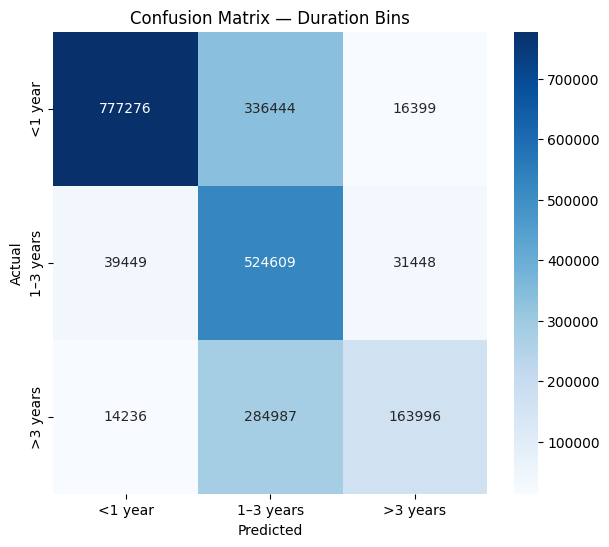

In [38]:
import numpy as np
import pandas as pd
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, classification_report
)
import seaborn as sns
import matplotlib.pyplot as plt

# ------------------------------------------------------
# 1. Define the 5-bin classifier function
# ------------------------------------------------------
def duration_to_class_5bins(x):
    if x < 365:
        return 0   # < 1 year
    elif x < 1095:
        return 1   # 1 to <3 years
    else :
        return 2   # >3 years
    

class_names = [
    "<1 year",
    "1–3 years",
    ">3 years"
]

# ------------------------------------------------------
# 2. Prepare true and predicted durations
#    (if you trained on log1p, do inverse transform)
# ------------------------------------------------------

y_test_true = np.array(y_test)        # or np.expm1(y_test_log)
y_pred_true = np.array(y_pred)        # or np.expm1(y_pred_log)

# ------------------------------------------------------
# 3. Convert durations → classes
# ------------------------------------------------------

y_test_cls = np.vectorize(duration_to_class_5bins)(y_test_true)
y_pred_cls = np.vectorize(duration_to_class_5bins)(y_pred_true)

# ------------------------------------------------------
# 4. Compute classification metrics
# ------------------------------------------------------

accuracy = accuracy_score(y_test_cls, y_pred_cls)
precision = precision_score(y_test_cls, y_pred_cls, average="weighted", zero_division=0)
recall = recall_score(y_test_cls, y_pred_cls, average="weighted", zero_division=0)
f1 = f1_score(y_test_cls, y_pred_cls, average="weighted", zero_division=0)

print("5-Bin Classification Performance:")
print("Accuracy:", accuracy)
print("Precision (weighted):", precision)
print("Recall (weighted):", recall)
print("F1 Score (weighted):", f1)

# ------------------------------------------------------
# 5. Detailed Classification Report
# ------------------------------------------------------

print("\nClassification Report:\n")
print(classification_report(y_test_cls, y_pred_cls, target_names=class_names, zero_division=0))

# ------------------------------------------------------
# 6. Confusion Matrix
# ------------------------------------------------------

cm = confusion_matrix(y_test_cls, y_pred_cls, labels=[0,1,2])
cm_df = pd.DataFrame(cm, index=class_names, columns=class_names)

plt.figure(figsize=(7,6))
sns.heatmap(cm_df, annot=True, fmt='d', cmap="Blues")
plt.title("Confusion Matrix — Duration Bins")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


In [14]:
# Now run the SAME model with engineered features for comparison
print("\n" + "="*70)
print("NOW TESTING WITH FEATURE ENGINEERING")
print("="*70)

def engineer_basic_features(df):
    """Create basic engineered features"""
    df_eng = df.copy()
    
    # 1. Temporal features (MOST IMPORTANT)
    df_eng['days_to_first_list'] = (df_eng['date_first_list'] - df_eng['date_of_filing']).dt.days
    df_eng['filing_month'] = df_eng['date_of_filing'].dt.month
    df_eng['filing_quarter'] = df_eng['date_of_filing'].dt.quarter
    df_eng['filing_year'] = df_eng['date_of_filing'].dt.year
    
    # 2. Case complexity
    df_eng['has_section'] = df_eng['section'].notna().astype(int)
    df_eng['multiple_sections'] = (df_eng['number_sections_ipc'] > 1).astype(int)
    
    # 3. Judge hierarchy
    def simplify_judge(pos):
        pos_str = str(pos).lower()
        if 'chief' in pos_str:
            return 'chief'
        elif 'district' in pos_str and 'sessions' in pos_str:
            return 'district_sessions'
        elif 'magistrate' in pos_str:
            return 'magistrate'
        elif 'additional' in pos_str:
            return 'additional'
        else:
            return 'other'
    
    df_eng['judge_type'] = df_eng['judge_position'].apply(simplify_judge)
    
    # 4. Act grouping
    top_acts = df_eng['act'].value_counts().head(10).index
    df_eng['act_group'] = df_eng['act'].apply(lambda x: x if x in top_acts else 'other')
    
    # 5. Gender features
    df_eng['female_involved'] = ((df_eng['female_defendant'] == 1) | (df_eng['female_petitioner'] == 1)).astype(int)
    df_eng['gender_same'] = (df_eng['female_defendant'] == df_eng['female_petitioner']).astype(int)
    
    # 6. State extraction
    df_eng['state_code'] = df_eng['state_district'].str.split('-').str[0]
    
    # 7. Fill missing
    df_eng['section'] = df_eng['section'].fillna(-1)
    df_eng['number_sections_ipc'] = df_eng['number_sections_ipc'].fillna(0)
    
    return df_eng

# Engineer features on the same sample
df_eng = engineer_basic_features(df_sample)

# Define engineered features
eng_features = [
    'days_to_first_list', 'filing_month', 'filing_quarter', 'filing_year',
    'has_section', 'multiple_sections', 'judge_type',
    'female_involved', 'gender_same', 'act_group', 
    'criminal', 'type_name', 'state_code', 'act', 'section'
]

# Prepare data with engineered features
df_ml_eng = df_eng[eng_features + ['case_duration_days']].copy()

# One-hot encode categoricals
categorical_cols = ['judge_type', 'act_group', 'state_code']
df_encoded_eng = pd.get_dummies(df_ml_eng, columns=categorical_cols)

X_eng = df_encoded_eng.drop('case_duration_days', axis=1)
y_eng = df_encoded_eng['case_duration_days']

# Remove NaN in target
mask_eng = y_eng.notna()
X_eng = X_eng[mask_eng]
y_eng = y_eng[mask_eng]

# Split
X_train_eng, X_test_eng, y_train_eng, y_test_eng = train_test_split(
    X_eng, y_eng, test_size=0.2, random_state=42
)

print(f"\n=== Engineered Features Summary ===")
print(f"Features used: {len(eng_features)} base features → {X_eng.shape[1]} after encoding")
print(f"Training samples: {len(X_train_eng):,}")
print(f"Testing samples:  {len(X_test_eng):,}")

# Train SAME model architecture
model_eng = RandomForestRegressor(
    n_estimators=200,
    max_depth=25,
    n_jobs=-1,
    random_state=42
)

print("\nTraining model with engineered features...")
model_eng.fit(X_train_eng, y_train_eng)

# Evaluate
y_pred_eng = model_eng.predict(X_test_eng)
mae_eng = mean_absolute_error(y_test_eng, y_pred_eng)
r2_eng = r2_score(y_test_eng, y_pred_eng)

# Baseline
baseline_mae_eng = mean_absolute_error(y_test_eng, [y_eng.mean()] * len(y_test_eng))

print(f"\n=== Model Performance (ENGINEERED FEATURES) ===")
print(f"Mean Absolute Error (MAE): {mae_eng:.2f} days")
print(f"R² Score: {r2_eng:.4f}")
print(f"Improvement over baseline: {(1 - mae_eng/baseline_mae_eng)*100:.1f}%")

# Compare with raw features
print(f"\n=== COMPARISON: Raw vs Engineered ===")
print(f"{'Metric':<25} {'Raw':>10} {'Engineered':>12} {'Change':>10}")
print(f"{'-'*57}")
print(f"{'R² Score':<25} {r2:>10.4f} {r2_eng:>12.4f} {r2_eng-r2:>+10.4f}")
print(f"{'MAE (days)':<25} {mae:>10.2f} {mae_eng:>12.2f} {mae_eng-mae:>+10.2f}")
print(f"{'% Improvement over baseline':<25} {100*(1-mae/baseline_mae):>10.1f}% {100*(1-mae_eng/baseline_mae_eng):>12.1f}%")

# Feature importance for engineered features
feature_importances_eng = pd.DataFrame({
    'feature': X_eng.columns,
    'importance': model_eng.feature_importances_
}).sort_values('importance', ascending=False)

print(f"\n=== Top 10 Engineered Features ===")
for i, (_, row) in enumerate(feature_importances_eng.head(10).iterrows(), 1):
    print(f"{i:2d}. {row['feature']:40s} : {row['importance']:.4f}")


NOW TESTING WITH FEATURE ENGINEERING

=== Engineered Features Summary ===
Features used: 15 base features → 60 after encoding
Training samples: 291,845
Testing samples:  72,962

Training model with engineered features...

=== Model Performance (ENGINEERED FEATURES) ===
Mean Absolute Error (MAE): 308.40 days
R² Score: 0.4530
Improvement over baseline: 40.1%

=== COMPARISON: Raw vs Engineered ===
Metric                           Raw   Engineered     Change
---------------------------------------------------------
R² Score                      0.4686       0.4530    -0.0155
MAE (days)                    303.93       308.40      +4.47
% Improvement over baseline       41.0%         40.1%

=== Top 10 Engineered Features ===
 1. days_to_first_list                       : 0.2614
 2. type_name                                : 0.1944
 3. section                                  : 0.1406
 4. filing_month                             : 0.0737
 5. act                                      : 0.0707
